## Aprendizaje de maquina - TP 5 (Prediccion de score en IMDB)

### Importando bibliotecas

Instalacion de biblioteca que tiene un encoder binario

In [117]:
pip install category_encoders

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import BinaryEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from yellowbrick.regressor import PredictionError, ResidualsPlot

### Carga y analisis de datos

In [119]:
imdb_data = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectIMDB/data/movie_metadata.csv")

In [120]:
imdb_data.head(3)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000


#### Analizando los tipos de dato

In [121]:
imdb_data.dtypes

color                         object
director_name                 object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_2_name                  object
actor_1_facebook_likes       float64
gross                        float64
genres                        object
actor_1_name                  object
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
actor_3_name                  object
facenumber_in_poster         float64
plot_keywords                 object
movie_imdb_link               object
num_user_for_reviews         float64
language                      object
country                       object
content_rating                object
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64
aspect_ratio                 float64
m

#### Cantidad de uniques por cada una de las variables categoricas

In [122]:
imdb_data['director_name'].value_counts()

Steven Spielberg     26
Woody Allen          22
Clint Eastwood       20
Martin Scorsese      20
Ridley Scott         17
                     ..
Tom Kalin             1
Kiyoshi Kurosawa      1
Dustin Hoffman        1
Hitoshi Matsumoto     1
Bonnie Hunt           1
Name: director_name, Length: 2398, dtype: int64

In [123]:
imdb_data['genres'].value_counts()

Drama                                         236
Comedy                                        209
Comedy|Drama                                  191
Comedy|Drama|Romance                          187
Comedy|Romance                                158
                                             ... 
Comedy|Crime|Drama|Horror|Mystery|Thriller      1
Adventure|Animation|Family|Sport                1
Adventure|Comedy|Crime|Drama|Family             1
Biography|Comedy|Drama|Music|Romance            1
Biography|Crime|Drama|History|Western           1
Name: genres, Length: 914, dtype: int64

In [124]:
imdb_data['actor_1_name'].value_counts()

Robert De Niro    49
Johnny Depp       41
Nicolas Cage      33
J.K. Simmons      31
Matt Damon        30
                  ..
Jason Stuart       1
Ed Speleers        1
Emily Podleski     1
Richard Coyle      1
Fergie             1
Name: actor_1_name, Length: 2097, dtype: int64

In [125]:
imdb_data['movie_title'].value_counts()

Ben-Hur                 3
Halloween               3
King Kong               3
Pan                     3
Victor Frankenstein     3
                       ..
In the Cut              1
Lady in White           1
Aloft                   1
Absentia                1
Race                    1
Name: movie_title, Length: 4917, dtype: int64

Puede observarse que hay muchas variables categoricas de alta cardinalidad (mas de 20 categorias). 

#### Analizando las distribuciones de las variables numericas

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2c39ff8650>,
      dtype=object)

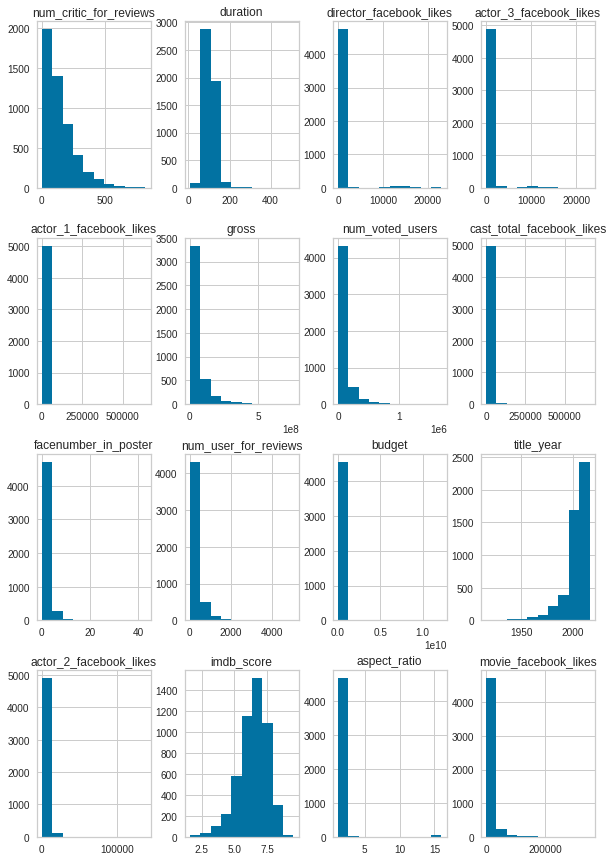

In [126]:
imdb_data.hist(figsize = (10,15))

Puede observarse que hay outliers en los likes de facebooks de los directores, y los terceros actores

#### Analisis de NaNs

In [127]:
nan_df = imdb_data.isnull().sum().reset_index()

In [128]:
nan_df.head()

,index,0
0,color,19
1,director_name,104
2,num_critic_for_reviews,50
3,duration,15
4,director_facebook_likes,104


In [129]:
imdb_data_not_nan = imdb_data.dropna()

In [130]:
nan_df = imdb_data_not_nan.isnull().sum().reset_index()

In [131]:
nan_df

,index,0
0,color,0
1,director_name,0
2,num_critic_for_reviews,0
3,duration,0
4,director_facebook_likes,0
5,actor_3_facebook_likes,0
6,actor_2_name,0
7,actor_1_facebook_likes,0
8,gross,0
9,genres,0


Ya no se tienen variables con NaN

### Preparacion de datos

In [149]:
imdb_df = imdb_data_not_nan.copy()

In [150]:
imdb_df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,Daryl Sabara,John Carter,212204,1873,Polly Walker,1.0,alien|american civil war|male nipple|mars|prin...,http://www.imdb.com/title/tt0401729/?ref_=fn_t...,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000


Drop de columna que no aportara significantemente al rating

In [151]:
imdb_df = imdb_df.drop(columns = ['movie_imdb_link'])

Encoding de variables categoricas (usando binary encoding) para tener todas variables numericas

In [152]:
encoder = BinaryEncoder(cols=[ 'color', 'director_name', 'actor_2_name', 'genres', 'actor_1_name', 'movie_title', 'actor_3_name', 'plot_keywords', 'language', 'country', 'content_rating']).fit(imdb_df)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [153]:
imdb_df_numeric_df = encoder.transform(imdb_df)

Separando en target y features

In [154]:
y_data = imdb_df_numeric_df['imdb_score']
x_data = imdb_df_numeric_df.drop('imdb_score', axis=1)

Separando en training set y test set

In [155]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.3)

### Creacion del modelo (Lineal con regularizacion lasso)


Creacion del modelo

In [156]:
model_linear_lasso = linear_model.Lasso(alpha = 0.2)
model_linear_lasso.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 954.0833782641831, tolerance: 0.29108478965386075
  positive)


Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Metricas de error

In [157]:
model_linear_lasso.score(x_train, y_train)

0.3567042678236803

In [158]:
model_linear_lasso.score(x_test, y_test)

0.3636432642781071

Los scores en training y test son similares, por lo que el modelo pareceria funcionar correctamente

### Metricas

#### Residual plot

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 954.0833782641831, tolerance: 0.29108478965386075
  positive)


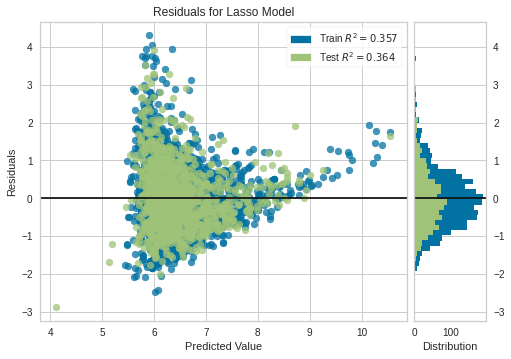

In [159]:
vis_res = ResidualsPlot(model_linear_lasso)


vis_res.fit(x_train, y_train)
vis_res.score(x_test, y_test)
g = vis_res.poof()

Puede observarse que el R2 es apenas mayor en train que en test, por lo que el overfitting es minimo

#### Prediction error plot

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 954.0833782641831, tolerance: 0.29108478965386075
  positive)


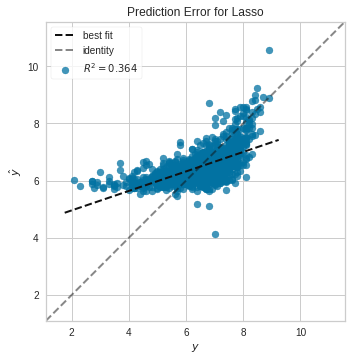

In [160]:
vis_pred_err = PredictionError(model_linear_lasso)

vis_pred_err.fit(x_train, y_train)
vis_pred_err.score(x_test, y_test)
g = vis_pred_err.poof()